In [244]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

# Import the Image and see the dimensions

In [381]:
im = plt.imread("Shazam.jpg")

im.shape

(381, 277, 3)

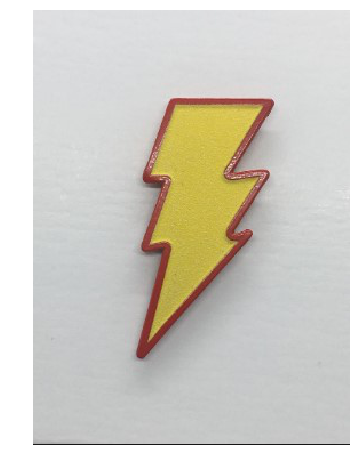

In [267]:
def plti(im, h=8, **kwargs):
    """
    Helper function to plot an image.
    """
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none", **kwargs)
    plt.axis('off')

plti(im)

# Crop the image

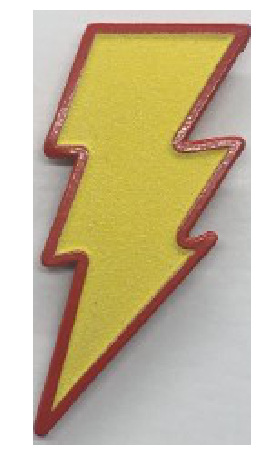

In [268]:
im = im[70:310,90:210,:]    
plti(im) #70:310 90:210

#  Colouration

Each pixel of the image is represented by three integers: the RGB value of its colour. Splitting the image into seperate colour components is just a matter of pulling out the correct slice of the image array. The coloration is depended on the data type. Float: 0-1 

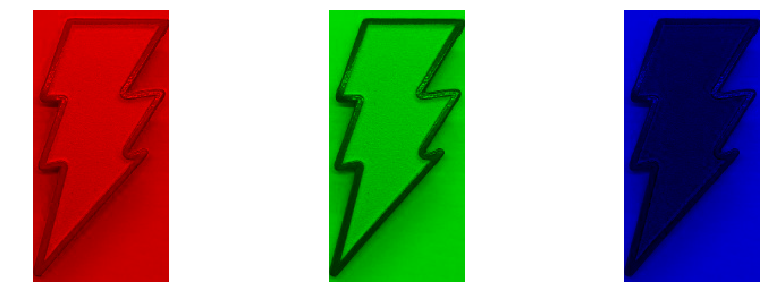

In [269]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for c, ax in zip(range(3), axs):
    tmp_im = np.zeros(im.shape, dtype="uint8")
    tmp_im[:,:,c] = im[:,:,c]
    ax.imshow(tmp_im)
    ax.set_axis_off()

# Colour Transformation

The above Images are axial endpoints of the colour plane in simpler terms every colour can be represented on the coordinate plane with an RGB value between 0-255. Also note all the legal colours have integer value

The following functions apply a sigmoid to the images colour space, and rotate it about the blue axis by some angle, before returning the image to normal colour space.

C:\Users\USER\ack\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


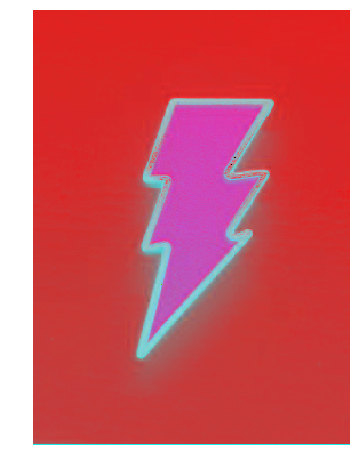

In [382]:
def do_normalise(im):
    return -np.log(1/((1 + im)/257) - 1)
 
def undo_normalise(im):
    return (1 + 1/(np.exp(-im) + 1) * 257).astype("uint8")

def rotation_matrix(theta):
    """
    3D rotation matrix around the X-axis by angle theta
    """
    return np.c_[
        [1,0,0],
        [0,np.cos(theta),-np.sin(theta)],
        [0,np.sin(theta),np.cos(theta)]
    ]

im_normed = do_normalise(im)
im_rotated = np.einsum("ijk,lk->ijl", im_normed, rotation_matrix(np.pi))
im2 = undo_normalise(im_rotated)

plti(im2)


#  Animation

Continously apply the above transformation function to get an Impressive animation.

In [271]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(5,8))

def update(i):
    im_normed = do_normalise(im)
    im_rotated = np.einsum("ijk,lk->ijl", im_normed, rotation_matrix(i * np.pi/10))
    im2 = undo_normalise(im_rotated)
    
    ax.imshow(im2)
    ax.set_title("Angle: {}*pi/10".format(i), fontsize=20)
    ax.set_axis_off()


anim = FuncAnimation(fig, update, frames=np.arange(0, 20), interval=500)
anim.save('colour_rotation.gif', dpi=50, writer='imagemagick')
plt.close()

# <img src="colour_rotation.gif">

MovieWriter imagemagick unavailable.
C:\Users\USER\ack\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


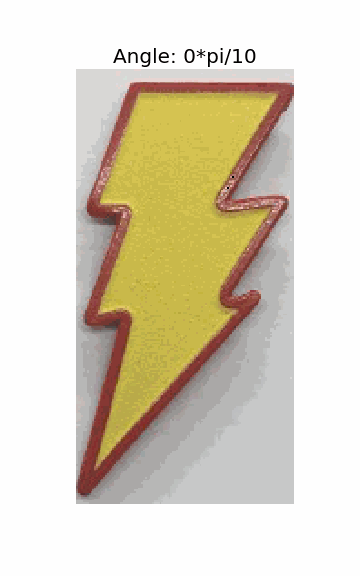

In [307]:
with open('colour_rotation.gif','rb') as f:
    display(Image(data=f.read(), format='gif'))


# Greyscale

In [273]:
def to_grayscale(im, weights = np.c_[0.2989, 0.5870, 0.1140]):
    """
    Transforms a colour image to a greyscale image by
    taking the mean of the RGB values, weighted
    by the matrix weights
    """
    tile = np.tile(weights, reps=(im.shape[0],im.shape[1],1))
    return np.sum(tile * im, axis=2)

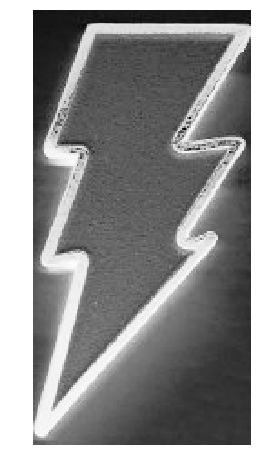

In [277]:
img = to_grayscale(im)

plti(img, cmap='Greys')

'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
            
            
            
             [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']


# Convoluted

Where C is the convoluted image, I is the original image and W is a window function. Essentially we are replacing each pixel with a weighted sum of nearby pixels.

In [278]:
from scipy.ndimage.interpolation import zoom
im_small = zoom(im, (0.2,0.2,1))

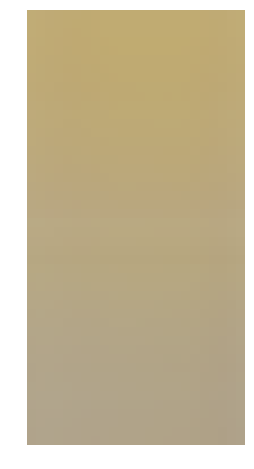

In [279]:
from scipy.signal import convolve2d

def convolve_all_colours(im, window):
    """
    Convolves im with window, over all three colour channels
    """
    ims = []
    for d in range(3):
        im_conv_d = convolve2d(im[:,:,d], window, mode="same", boundary="symm")
        ims.append(im_conv_d)

    im_conv = np.stack(ims, axis=2).astype("uint8")
    
    return im_conv

n=50
window = np.ones((n,n))
window /= np.sum(window)
plti(convolve_all_colours(im_small, window))

# Types of blur filters with window sizes 

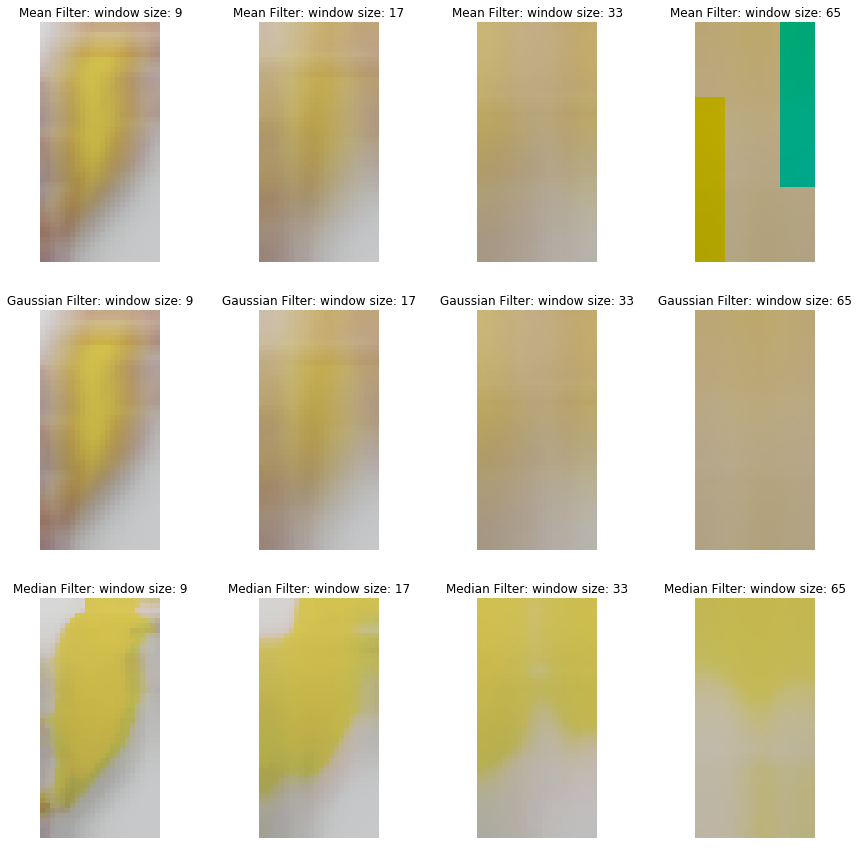

In [280]:
from scipy.ndimage import median_filter

def make_gaussian_window(n, sigma=1):
    """
    Creates a square window of size n by n of weights from a gaussian
    of width sigma.
    """
    nn = int((n-1)/2)
    a = np.asarray([[x**2 + y**2 for x in range(-nn,nn+1)] for y in range(-nn,nn+1)])
    return np.exp(-a/(2*sigma**2))

def median_filter_all_colours(im_small, window_size):
    """
    Applies a median filer to all colour channels
    """
    ims = []
    for d in range(3):
        im_conv_d = median_filter(im_small[:,:,d], size=(window_size,window_size))
        ims.append(im_conv_d)

    im_conv = np.stack(ims, axis=2).astype("uint8")
    
    return im_conv

window_sizes = [9,17,33,65]
fig, axs = plt.subplots(nrows=3, ncols=len(window_sizes), figsize=(15,15));



# mean filter
for w, ax in zip(window_sizes, axs[0]):
    window = np.ones((w,w))
    window /= np.sum(window)
    ax.imshow(convolve_all_colours(im_small, window));
    ax.set_title("Mean Filter: window size: {}".format(w));
    ax.set_axis_off();
    
# gaussian filter
for w, ax in zip(window_sizes, axs[1]):
    window = make_gaussian_window(w,sigma=w)
    window /= np.sum(window)
    ax.imshow(convolve_all_colours(im_small, window));
    ax.set_title("Gaussian Filter: window size: {}".format(w));
    ax.set_axis_off();
    
# median filter
for w, ax in zip(window_sizes, axs[2]):
    ax.imshow(median_filter_all_colours(im_small, w));
    ax.set_title("Median Filter: window size: {}".format(w));
    ax.set_axis_off();


Wall time: 27 ms


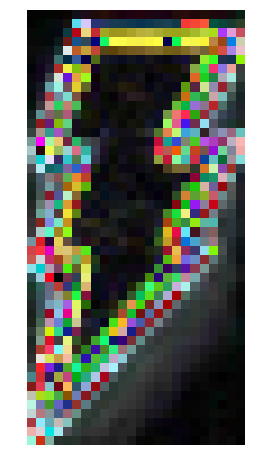

In [314]:
%%time

n=100
sobel_x = np.c_[
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]

sobel_y = np.c_[
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
]

ims = []
for d in range(3):
    sx = convolve2d(im_small[:,:,d], sobel_x, mode="same", boundary="symm")
    sy = convolve2d(im_small[:,:,d], sobel_y, mode="same", boundary="symm")
    ims.append(np.sqrt(sx*sx + sy*sy))

im_conv = np.stack(ims, axis=2).astype("uint8")

plti(im_conv)

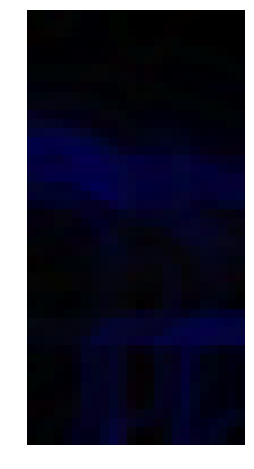

In [317]:
im_smoothed = median_filter_all_colours(im_small, 71)

sobel_x = np.c_[
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]

sobel_y = np.c_[
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
]

ims = []
for d in range(3):
    sx = convolve2d(im_smoothed[:,:,d], sobel_x, mode="same", boundary="symm")
    sy = convolve2d(im_smoothed[:,:,d], sobel_y, mode="same", boundary="symm")
    ims.append(np.sqrt(sx*sx + sy*sy))

im_conv = np.stack(ims, axis=2).astype("uint8")

plti(im_conv)

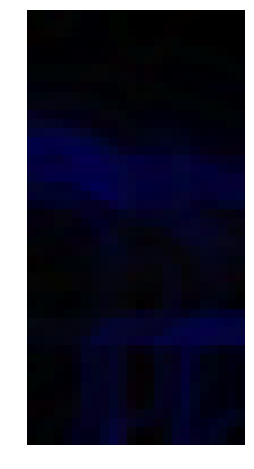

In [320]:
im_smoothed = median_filter_all_colours(im_small, 71)

sobel_x = np.c_[
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]

sobel_y = np.c_[
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
]

ims = []
for d in range(3):
    sx = convolve2d(im_smoothed[:,:,d], sobel_x, mode="same", boundary="symm")
    sy = convolve2d(im_smoothed[:,:,d], sobel_y, mode="same", boundary="symm")
    ims.append(np.sqrt(sx*sx + sy*sy))

im_conv = np.stack(ims, axis=2).astype("uint8")

plti(im_conv)

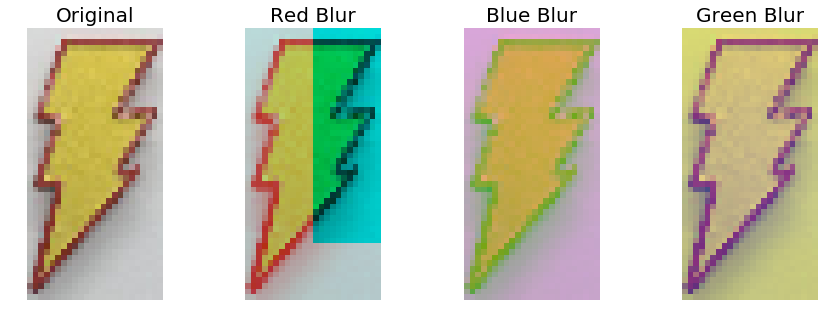

In [321]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,5))

ax= axs[0]
ax.imshow(im_small)
ax.set_title("Original", fontsize=20)
ax.set_axis_off()

w=75
window = np.ones((w,w))
window /= np.sum(window)

ax= axs[1]
ims = []
for d in range(3):
    if d == 0:
        im_conv_d = convolve2d(im_small[:,:,d],window, mode="same", boundary="symm")
    else:
        im_conv_d = im_small[:,:,d]
    ims.append(im_conv_d)
ax.imshow(np.stack(ims, axis=2).astype("uint8"))
ax.set_title("Red Blur", fontsize=20)
ax.set_axis_off()

ax= axs[2]
ims = []
for d in range(3):
    if d == 1:
        im_conv_d = convolve2d(im_small[:,:,d], window, mode="same", boundary="symm")
    else:
        im_conv_d = im_small[:,:,d]
    ims.append(im_conv_d)
ax.imshow(np.stack(ims, axis=2).astype("uint8"))
ax.set_title("Blue Blur", fontsize=20)
ax.set_axis_off()

ax= axs[3]
ims = []
for d in range(3):
    if d == 2:
        im_conv_d = convolve2d(im_small[:,:,d], window, mode="same", boundary="symm")
    else:
        im_conv_d = im_small[:,:,d]
    ims.append(im_conv_d)
ax.imshow(np.stack(ims, axis=2).astype("uint8"))
ax.set_title("Green Blur", fontsize=20)
ax.set_axis_off()

# Segmentation

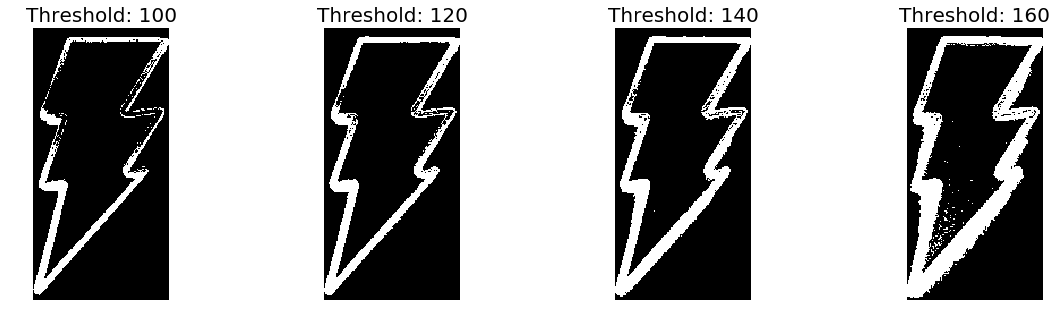

In [324]:
def simple_threshold(im, threshold=128):
    return ((im > threshold) * 255).astype("uint8")

thresholds = [100,120,140,160]

fig, axs = plt.subplots(nrows=1, ncols=len(thresholds), figsize=(20,5));
gray_im = to_grayscale(im)
                        
for t, ax in zip(thresholds, axs):
    ax.imshow(simple_threshold(gray_im, t), cmap='Greys');
    ax.set_title("Threshold: {}".format(t), fontsize=20);
    ax.set_axis_off();


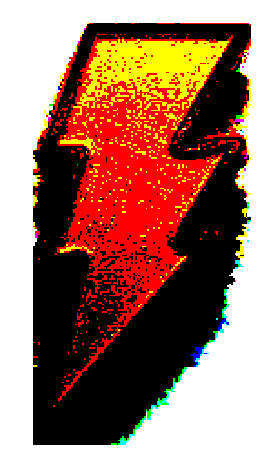

In [341]:
def otsu_threshold(im):

    pixel_counts = [np.sum(im == i) for i in range(256)]

    s_max = (0,-10)
    ss = []
    for threshold in range(256):

        # update
        w_0 = sum(pixel_counts[:threshold])
        w_1 = sum(pixel_counts[threshold:])

        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)]) / w_0  if w_0 > 0 else 0       
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 160)]) / w_1  if w_1 > 0 else 0

        # calculate 
        s = w_0 * w_1 * (mu_0 - mu_1) ** 2
        ss.append(s)

        if s > s_max[1]:
            s_max = (threshold, s)
            
    return s_max[0]

t = otsu_threshold(im)
plti(simple_threshold(im, t), cmap='Greys')

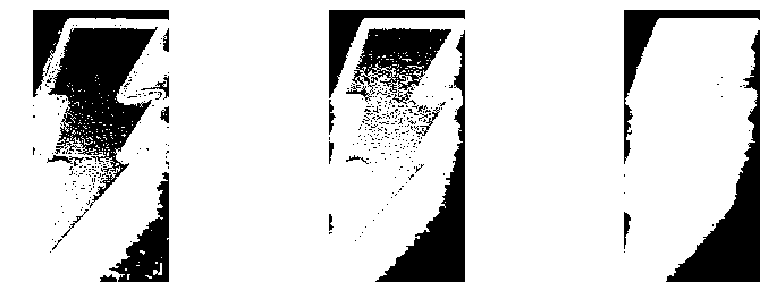

In [349]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

c_ims = []
for c, ax in zip(range(3), axs):
    tmp_im = im[:,:,c]
    t = otsu_threshold(tmp_im)
    tmp_im = simple_threshold(tmp_im, t)
    ax.imshow(tmp_im, cmap='Greys')
    c_ims.append(tmp_im)
    ax.set_axis_off()

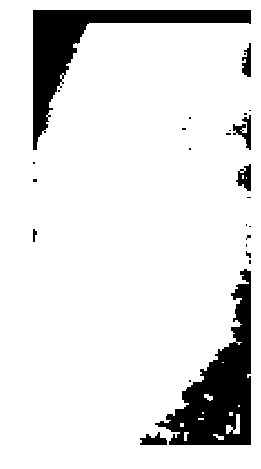

In [350]:
plti(c_ims[0] & c_ims[1] & c_ims[2], cmap='Greys')

We can be more direct in our approach though. In Otsu thresholding, we found the threshold which minimised the inter-segment pixel variance. If rather then looking for a threshold, we look for clusters in colour space, we end up with the K-means clustering technique. Applying this directed to the coloured image, we get

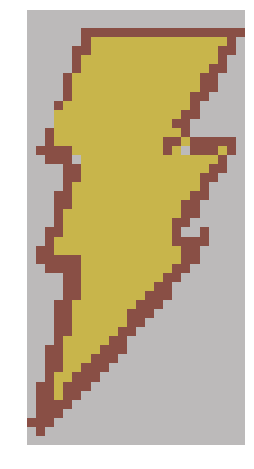

In [352]:
from sklearn.cluster import KMeans

h,w = im_small.shape[:2]
im_small_long = im_small.reshape((h * w, 3))
im_small_wide = im_small_long.reshape((h,w,3))

km = KMeans(n_clusters=3)

km.fit(im_small_long)

cc = km.cluster_centers_.astype(np.uint8)
out = np.asarray([cc[i] for i in km.labels_]).reshape((h,w,3))

plti(out)

Random assignment in each segment

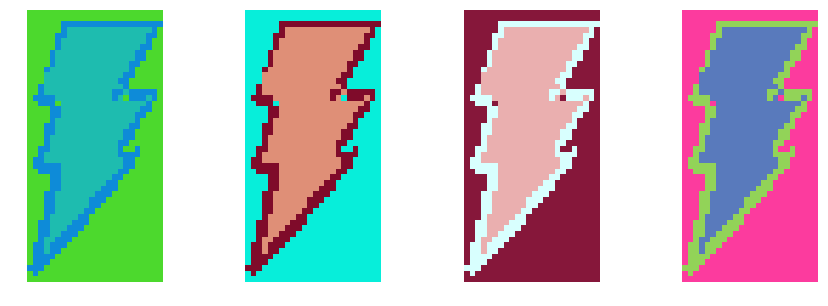

In [357]:
rng = range(4)

fig, axs = plt.subplots(nrows=1, ncols=len(rng), figsize=(15,5))
gray_im = to_grayscale(im)
                        
for t, ax in zip(rng, axs):
    rnd_cc = np.random.randint(0,256, size = (3,3))
    out = np.asarray([rnd_cc[i] for i in km.labels_]).reshape((h,w,3))
    ax.imshow(out)
    ax.set_axis_off()

# Vectorization

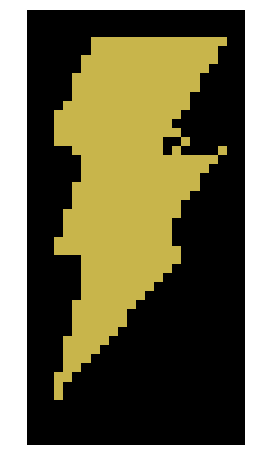

In [358]:
ki = np.asarray([cc[i] if i == 1 else [0,0,0]
                  for i in km.labels_]).reshape((h,w,3))

plti(ki)

Contour tracing

C:\Users\USER\ack\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


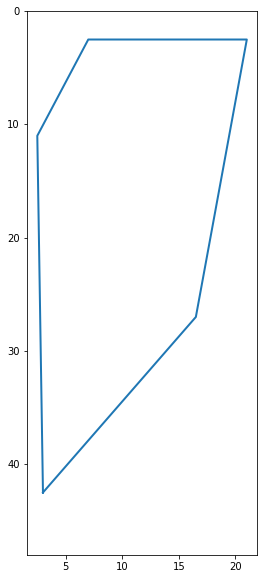

In [369]:
from skimage import measure

seg = np.asarray([(1 if i == 1 else 0)
                  for i in km.labels_]).reshape((h,w))

contours = measure.find_contours(seg, 0.5, fully_connected="high")

simplified_contours = [measure.approximate_polygon(c, tolerance=5) for c in contours]

plt.figure(figsize=(5,10))

for n, contour in enumerate(simplified_contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
    
plt.ylim(h,0)
plt.axes().set_aspect('equal')

C:\Users\USER\ack\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


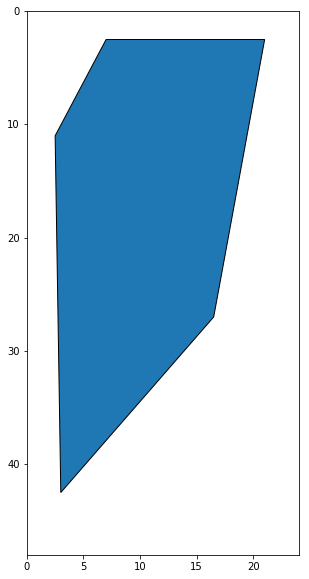

In [362]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path

# flip the path coordinates so it is consistent with matplotlib
paths = [[[v[1], v[0]] for v in vs] for vs in simplified_contours]

def get_path(vs):
    codes = [Path.MOVETO] + [Path.LINETO] * (len(vs)-2) + [Path.CLOSEPOLY]
    return PathPatch(Path(vs, codes))

plt.figure(figsize=(5,10))

ax = plt.gca()

for n, path in enumerate(paths):
    ax.add_patch(get_path(path))


    
plt.ylim(h,0)
plt.xlim(0,w)

plt.axes().set_aspect('equal')

In [363]:
class Polygon:
    def __init__(self, outer, inners):
        self.outer = outer
        self.inners = inners
        
    def clone(self):
        return Polygon(self.outer[:], [c.clone() for c in self.inners])

def crosses_line(point, line):
    """
    Checks if the line project in the positive x direction from point
    crosses the line between the two points in line
    """
    p1,p2 = line
    
    x,y = point
    x1,y1 = p1
    x2,y2 = p2
    
    if x <= min(x1,x2) or x >= max(x1,x2):
        return False
    
    dx = x1 - x2
    dy = y1 - y2
    
    if dx == 0:
        return True
    
    m = dy / dx
    
    
    
    if y1 + m * (x - x1) <= y:
        return False
    
    return True

def point_within_polygon(point, polygon):
    """
    Returns true if point within polygon
    """
    crossings = 0
    
    for i in range(len(polygon.outer)-1):
        line = (polygon.outer[i], polygon.outer[i+1])
        crossings += crosses_line(point, line)
        
    if crossings % 2 == 0:
        return False
    
    return True

def polygon_inside_polygon(polygon1, polygon2):
    """
    Returns true if the first point of polygon1 is inside 
    polygon 2
    """
    return point_within_polygon(polygon1.outer[0], polygon2)


def subsume(original_list_of_polygons):
    """
    Takes a list of polygons and returns polygons with insides.
    
    This function makes the unreasonable assumption that polygons can
    only be complete contained within other polygons (e.g. not overlaps).
    
    In the case where polygons are nested more then three levels, 
    """
    list_of_polygons = [p.clone() for p in original_list_of_polygons]
    polygons_outside = [p for p in list_of_polygons
                        if all(not polygon_inside_polygon(p, p2) 
                               for p2 in list_of_polygons 
                               if p2 != p)]
    
    polygons_inside = [p for p in list_of_polygons
                        if any(polygon_inside_polygon(p, p2) 
                               for p2 in list_of_polygons
                               if p2 != p)]
    
    for outer_polygon in polygons_outside:
        for inner_polygon in polygons_inside:
            if polygon_inside_polygon(inner_polygon, outer_polygon):
                outer_polygon.inners.append(inner_polygon)
                
    return polygons_outside
                
    for p in polygons_outside:
        p.inners = subsume(p.inners)
        
    return polygons_outside

In [364]:
polygons = [Polygon(p,[]) for p in paths]
subsumed_polygons = subsume(polygons)


In [365]:
def build_path_patch(polygon, **kwargs):
    """
    Builds a matplotlb patch to plot a complex polygon described
    by the Polygon class.
    """
    verts = polygon.outer[:]
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts)-2) + [Path.CLOSEPOLY]

    for inside_path in polygon.inners:
        verts_tmp = inside_path.outer
        codes_tmp = [Path.MOVETO] + [Path.LINETO] * (len(verts_tmp)-2) + [Path.CLOSEPOLY]

        verts += verts_tmp
        codes += codes_tmp

    drawn_path = Path(verts, codes)

    return PathPatch(drawn_path, **kwargs)

C:\Users\USER\ack\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


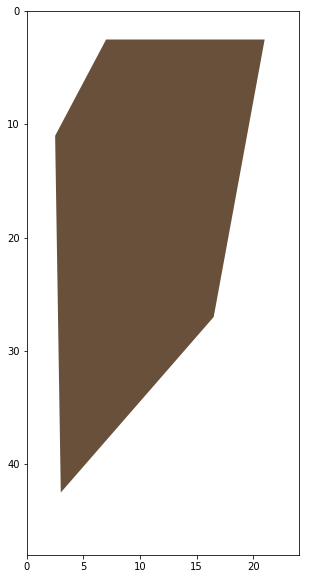

In [366]:
def rnd_color():
    """Returns a randon (R,G,B) tuple"""
    return tuple(np.random.random(size=3))

plt.figure(figsize=(5,10))
ax = plt.gca()  
c = rnd_color()

for n, polygon in enumerate(subsumed_polygons):
    ax.add_patch(build_path_patch(polygon, lw=0, facecolor=c))
    
plt.ylim(h,0)
plt.xlim(0,w)
plt.axes().set_aspect('equal')
plt.show()
